# Neural Network Evaluation and Visualization

Load the trained model, evaluate predictions with confidence scores, and visualize training performance.

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from medmnist import OrganMNIST3D

# Load datasets
test_dataset = OrganMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float16)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float16)

# Class names
class_names = [
    "Spleen", "Right Kidney", "Left Kidney", "Gallbladder", "Esophagus",
    "Liver", "Stomach", "Aorta", "Inferior Vena Cava", "Pancreas", "Adrenal Gland"
]

print(f"Test dataset loaded: {len(testx)} images")

Test dataset loaded: 610 images


In [ ]:
#Load the trained model -- You need to copy the function from the other notebook and make sure they are loading the same model
def myNet():
    model = tf.keras.Sequential(layers=[
        tf.keras.layers.InputLayer(shape=(1, 28, 28, 28)),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', bias_initializer='zeros', data_format='channels_first'),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', bias_initializer='zeros', data_format='channels_first'),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(11, activation='softmax', name='output')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Model loaded successfully from epoch_2.weights.h5


In [16]:
model = myNet()
model.load_weights('checkpoints/epoch_2.weights.h5') 
print("Model loaded successfully from epoch_2.weights.h5")

Model loaded successfully from epoch_2.weights.h5


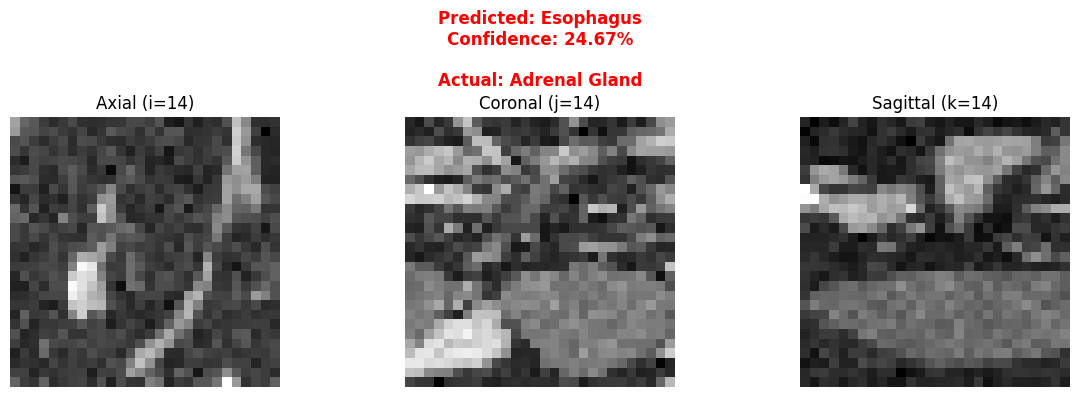

In [11]:
# Visualize predictions with confidence scores
def visualize_prediction(image_idx):
    """Show a test image with model prediction and confidence"""
    vol = np.squeeze(testx[image_idx], axis=0)
    
    # Get prediction
    img_tensor = tf.expand_dims(testx_tensor[image_idx], axis=0)
    prediction = model.predict(img_tensor, verbose=0)
    pred_class = np.argmax(prediction[0])
    confidence = prediction[0][pred_class]
    true_class = int(np.asarray(testy[image_idx]).squeeze())
    
    # Show middle slices
    i_mid = vol.shape[0] // 2
    j_mid = vol.shape[1] // 2
    k_mid = vol.shape[2] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(vol[i_mid, :, :], cmap='gray')
    axes[0].set_title(f'Axial (i={i_mid})')
    axes[0].axis('off')
    
    axes[1].imshow(vol[:, j_mid, :], cmap='gray')
    axes[1].set_title(f'Coronal (j={j_mid})')
    axes[1].axis('off')
    
    axes[2].imshow(vol[:, :, k_mid], cmap='gray')
    axes[2].set_title(f'Sagittal (k={k_mid})')
    axes[2].axis('off')
    
    # Add prediction info
    pred_text = f"Predicted: {class_names[pred_class]}\nConfidence: {confidence:.2%}\n\nActual: {class_names[true_class]}"
    color = 'green' if pred_class == true_class else 'red'
    fig.suptitle(pred_text, fontsize=12, color=color, weight='bold')
    
    plt.tight_layout()
    plt.show()

# Try different image indices (0 to len(testx)-1)
visualize_prediction(0)

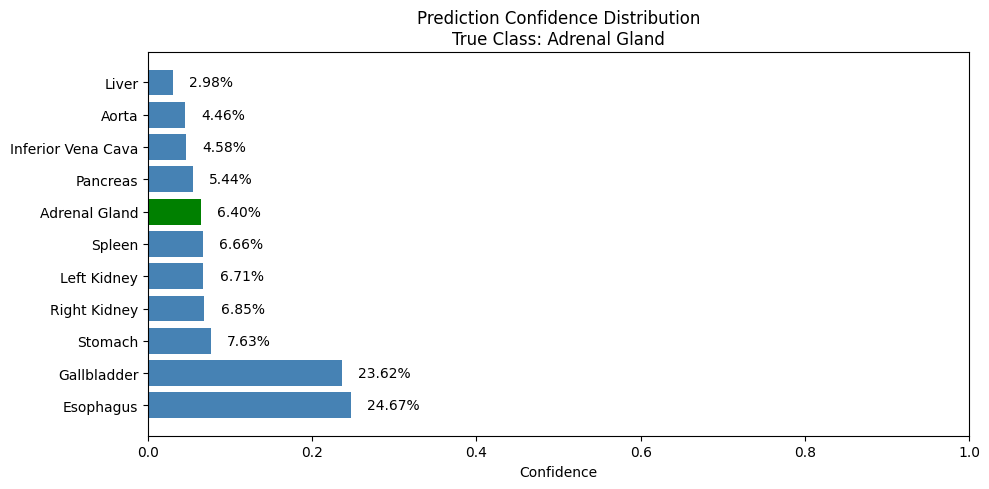

In [12]:
# Confidence distribution: show top predictions for an image
def show_confidence_distribution(image_idx):
    """Bar chart showing confidence for all classes"""
    img_tensor = tf.expand_dims(testx_tensor[image_idx], axis=0)
    prediction = model.predict(img_tensor, verbose=0)[0]
    
    true_class = int(np.asarray(testy[image_idx]).squeeze())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Sort by confidence
    sorted_indices = np.argsort(prediction)[::-1]
    sorted_names = [class_names[i] for i in sorted_indices]
    sorted_confidence = prediction[sorted_indices]
    
    colors_list = ['green' if i == true_class else 'steelblue' for i in sorted_indices]
    ax.barh(sorted_names, sorted_confidence, color=colors_list)
    ax.set_xlabel('Confidence')
    ax.set_title(f'Prediction Confidence Distribution\nTrue Class: {class_names[true_class]}')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for i, v in enumerate(sorted_confidence):
        ax.text(v + 0.02, i, f'{v:.2%}', va='center')
    
    plt.tight_layout()
    plt.show()

show_confidence_distribution(0)

# Training History Visualization

Note: This requires saving training history from the train.ipynb file. Update train.ipynb to save the history object.

In [14]:
# If you want to plot training history, you need to save it from train.ipynb
# Uncomment below and update the path if you save training_history as a pickle file

# import pickle
# with open('training_history.pkl', 'rb') as f:
#     training_history = pickle.load(f)

# For now, we'll create a function to plot if history exists
def plot_training_history(history):
    """Plot accuracy and loss curves from training history"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy Over Training')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss Over Training')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Function defined. To use: pass the training_history object from train.ipynb")
print("Example: plot_training_history(training_history)")

Function defined. To use: pass the training_history object from train.ipynb
Example: plot_training_history(training_history)


In [15]:
# Test set accuracy summary
test_loss, test_acc = model.evaluate(testx_tensor, testy_tensor, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 16.39%
Test Loss: 2.6867
